# 1. Install neccesarry libraries

In [27]:
 # This is a library for image reshaping
!pip install Pillow 

!pip install keras 
!pip install tensorflow -- quiet


#Import neccesary libraries
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
from PIL import Image



#Import the neccesary libraries for the model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization,MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers


ERROR: Could not find a version that satisfies the requirement quiet (from versions: none)
ERROR: No matching distribution found for quiet


# 2. Read the csv files and exploration


We will have 2 different csv files. 

First one *'GroundTruth.csv '* contains images_id with their labes.

And the other one *'HAM10000_metadata.csv'* is contains a informations regading the image itself.



## 2.1 Reading CSV files and concatanate 

In [2]:
#Read the csv files into a dataframe

df = pd.read_csv('GroundTruth.csv')

df2 = pd.read_csv('HAM10000_metadata.csv')

df.head(5)

#!ls "./images/images" #Before preprocessing checked directory 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   10015 non-null  object 
 1   MEL     10015 non-null  float64
 2   NV      10015 non-null  float64
 3   BCC     10015 non-null  float64
 4   AKIEC   10015 non-null  float64
 5   BKL     10015 non-null  float64
 6   DF      10015 non-null  float64
 7   VASC    10015 non-null  float64
dtypes: float64(7), object(1)
memory usage: 626.1+ KB


In [3]:
df2.head(5)

df2.info()

#As we can see in df2 the column with image_id is different than the one in df.
#We need to change the column name in df2 to match the one in df

df2 = df2.rename(columns={'image_id': 'image'},inplace=False)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


### 2.1.1 Data Cleaning  

 We can see from previous cell, there is non-null values from age

Lets check it 

In [4]:
df2.isnull().sum()


lesion_id        0
image            0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [5]:
#Since we see age column has some non values we need to adjust them with mean value

df2['age'].fillna((df2['age'].mean()), inplace=True)

df2.isnull().sum()

lesion_id       0
image           0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

## 2.2 Dataframe Concatenation

In order to make a analysis based on the images we can concatenate both dataframes to one 

In [6]:
#Merge the two dataframes on the image_id column

df3 = pd.merge(df, df2, on='image')

df3.head(5)

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC    lesion_id   dx  \
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0  HAM_0000550   nv   
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0  HAM_0003577   nv   
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0  HAM_0001477   nv   
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0  HAM_0000484   nv   
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0  HAM_0003350  mel   

     dx_type   age     sex     localization  
0  follow_up  45.0    male            trunk  
1  follow_up  50.0    male  lower extremity  
2  follow_up  55.0  female            trunk  
3  follow_up  40.0    male            trunk  
4      histo  60.0    male            chest

In [7]:
#Show the number of columns we have to proccess
print(len(df))

#Show the columns we have to proccess
print(df.columns)

#drop the image column from the dataframe so that create a label array

labels = df.drop(columns=['image'])

10015
Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')


In [8]:
#From above we can see that our dataframe is not contain .jpg extension so we have to add it to the dataframe
#This will help us to read the images from the directory

df['image'] = df['image'].apply(lambda x: x + '.jpg')

print(df.head())

              image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310.jpg  1.0  0.0  0.0    0.0  0.0  0.0   0.0


# 3. Data preprocessing

## 3.1 Resizing the images

Resizing images will be helpful for us to work on models.

This images are formed as RGB which is Red,Green and Blue Channels.

When re-size the images as (128,128) it will create a a column as 128x128x3 = 49152 

In [9]:
import os
from IPython.display import Image, display

from PIL import Image

image_directory = './images/images' 

#We need to end of the file as jnp because in the directory there is .txt file
image_files = [os.path.join(image_directory, file) for file in os.listdir(image_directory) if file.endswith('.jpg')]

#Sort the images based on their indexis
image_files.sort()

count = 0

#Resize the images to 128x128
resized_images = []
for image_file in image_files:
    
    with Image.open(image_file) as img:
    
        img = img.resize((128,128))
        #Make sure that the image is RGB and convert it to numpy array
        img_array = np.array(img)

        #Normalize the image
        img = img_array/ 255.0


        #print(img.size)
        resized_images.append(img_array)


#This shows the shape of my images and the min and max values of the pixels
#This will help us to see if there is any problem with the images
img_array.shape, img_array.min(), img_array.max()

((128, 128, 3), 15, 239)

In [10]:
#This convertion is neccesarry since we are feeding the images to the neural network as numpy array 
# numpy make it as 4 dimensional array, before proccesing we had 3 dimensional array
X = np.array(resized_images)

X.shape

(10015, 128, 128, 3)

Create a two dictionaries to show the each cancer type.

First one is for labeling within given dataftrame.

Second one works as changin the labels with appropiate biological classification

Each key values corresponded with cancer type and as their values, image paths are linked

In [11]:
from collections import defaultdict

cancer_images = defaultdict(list)

#we will take 5 different images for each cancer type
#In order to do it we need to create a dictionary with contain cancer types and corresponding images
num_images = 5

#Iterate over the dataframe and append the images to the dictionary
for i, r in df3.iterrows():
    c_type = r['dx'] #cancer type
    image_f = r['image'] # image file name
    image_f =image_f +'.jpg'

    if len(cancer_images[c_type]) < num_images: # Control the number of images
        cancer_images[c_type].append(image_f)

cancer_images.values()

#cancer_images



dict_values([['ISIC_0024306.jpg', 'ISIC_0024307.jpg', 'ISIC_0024308.jpg', 'ISIC_0024309.jpg', 'ISIC_0024311.jpg'], ['ISIC_0024310.jpg', 'ISIC_0024313.jpg', 'ISIC_0024315.jpg', 'ISIC_0024323.jpg', 'ISIC_0024333.jpg'], ['ISIC_0024312.jpg', 'ISIC_0024324.jpg', 'ISIC_0024336.jpg', 'ISIC_0024337.jpg', 'ISIC_0024338.jpg'], ['ISIC_0024318.jpg', 'ISIC_0024330.jpg', 'ISIC_0024386.jpg', 'ISIC_0024396.jpg', 'ISIC_0024553.jpg'], ['ISIC_0024329.jpg', 'ISIC_0024372.jpg', 'ISIC_0024418.jpg', 'ISIC_0024450.jpg', 'ISIC_0024463.jpg'], ['ISIC_0024331.jpg', 'ISIC_0024332.jpg', 'ISIC_0024345.jpg', 'ISIC_0024360.jpg', 'ISIC_0024403.jpg'], ['ISIC_0024370.jpg', 'ISIC_0024375.jpg', 'ISIC_0024402.jpg', 'ISIC_0024475.jpg', 'ISIC_0024662.jpg']])

In [12]:
#For simplicity and more accurate usage of data we will show real names of the cancer types
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

#Now we will map the cancer types to their real names from previous cancer_images dictionary

cancer_images_names = defaultdict(list)

for k, v in cancer_images.items():
    cancer_images_names[lesion_type_dict[k]] = v

cancer_images_names.keys()


dict_keys(['Melanocytic nevi', 'Melanoma', 'Benign keratosis-like lesions ', 'Dermatofibroma', 'Actinic keratoses', 'Basal cell carcinoma', 'Vascular lesions'])

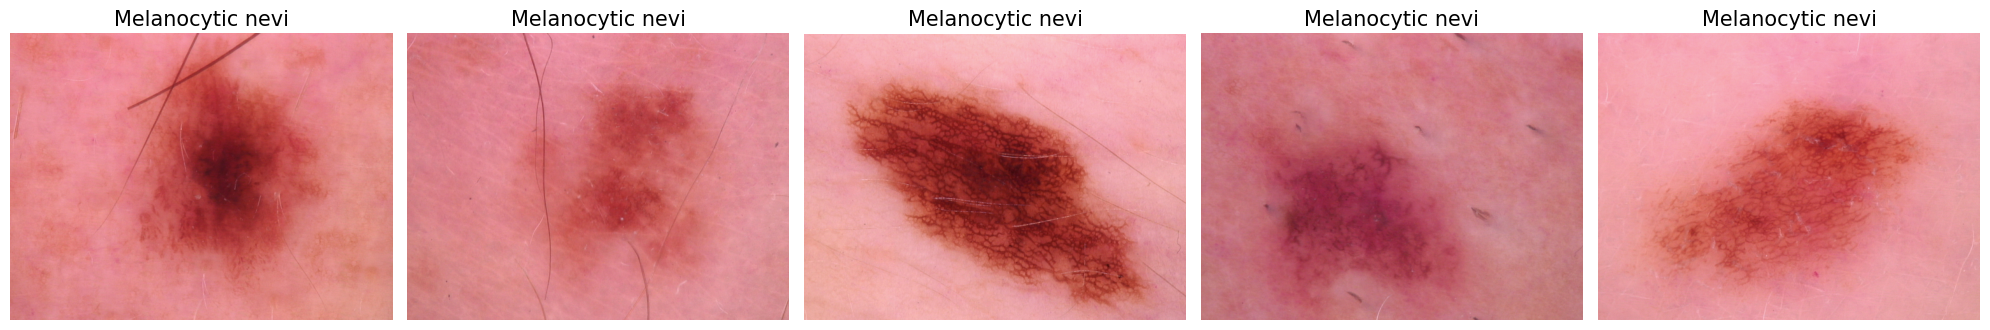

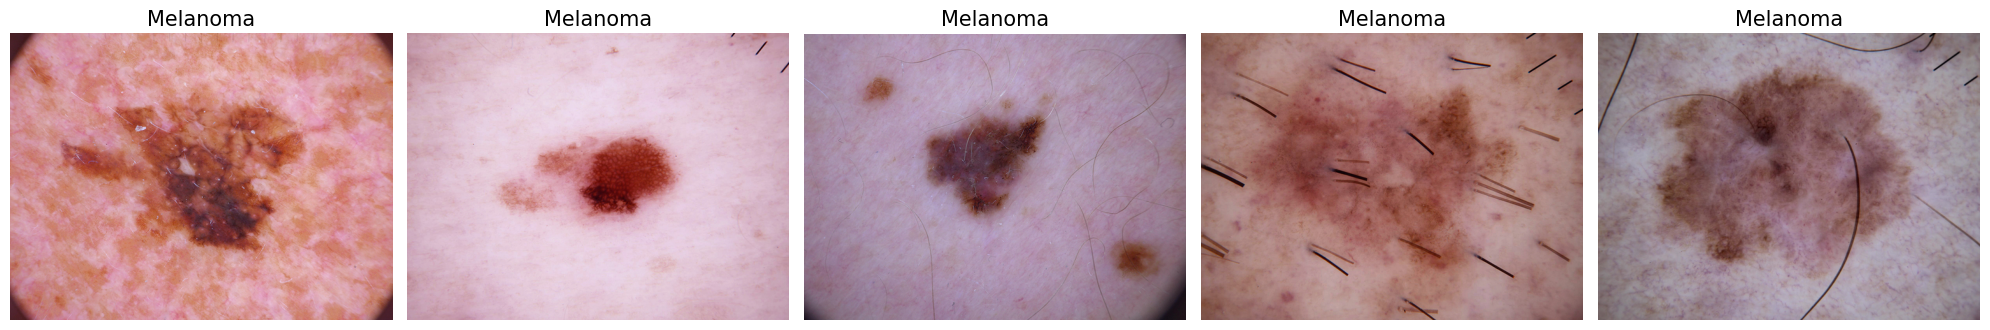

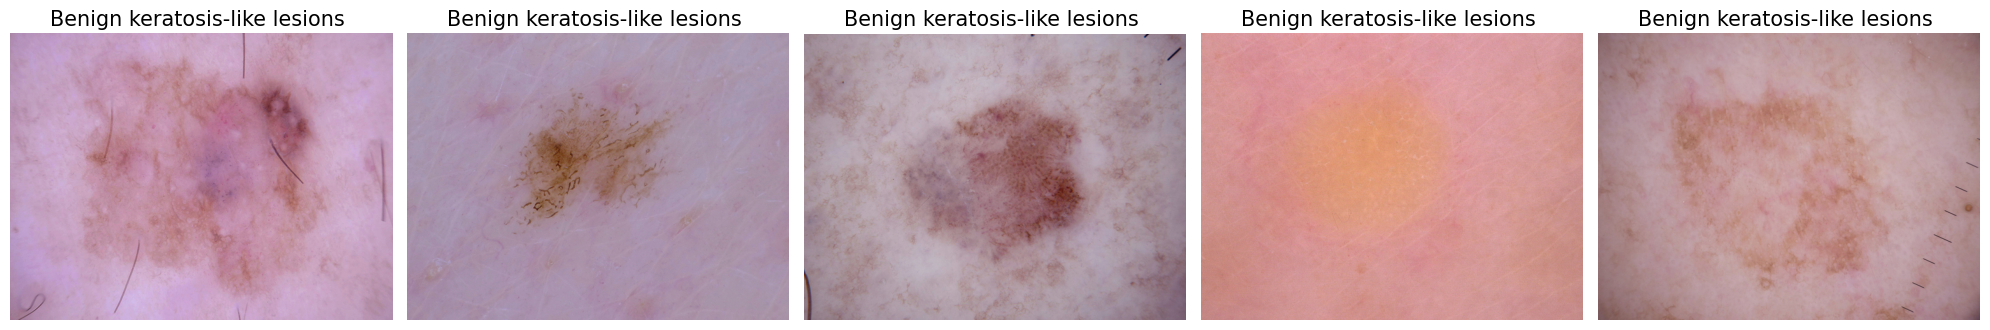

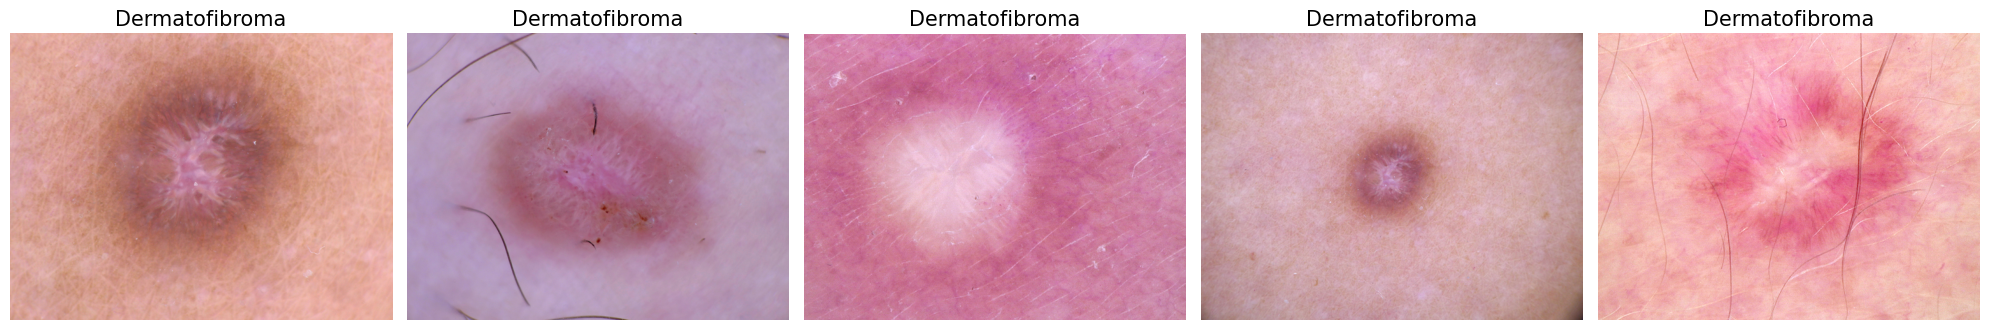

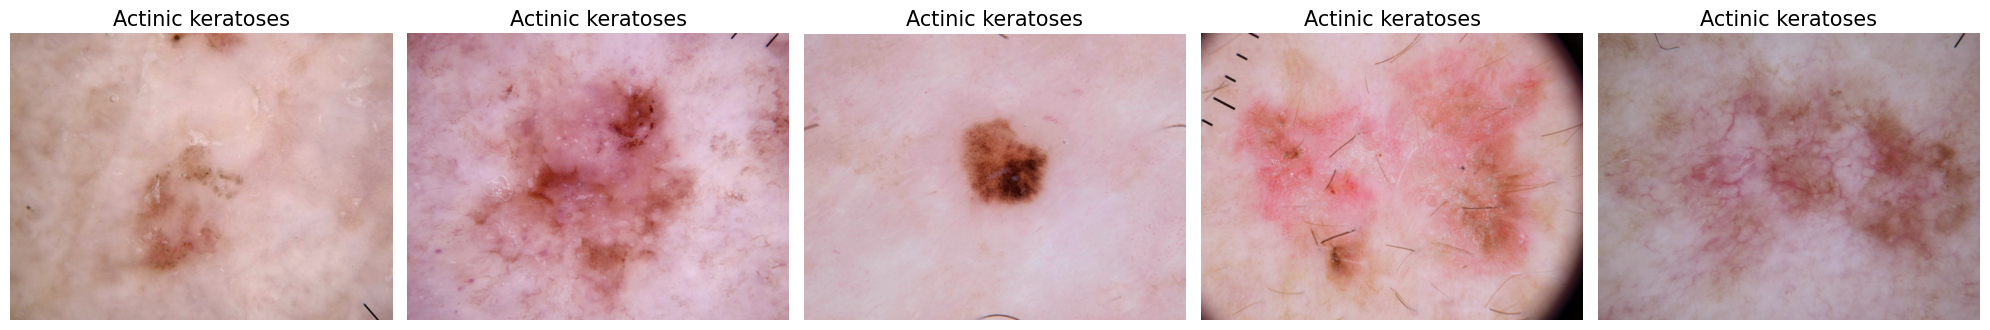

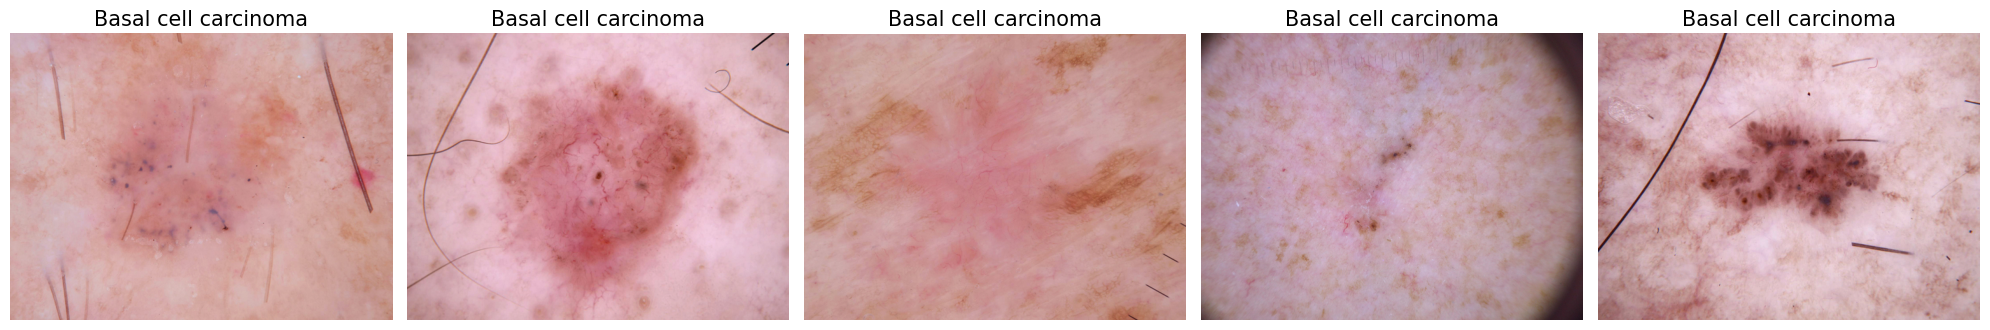

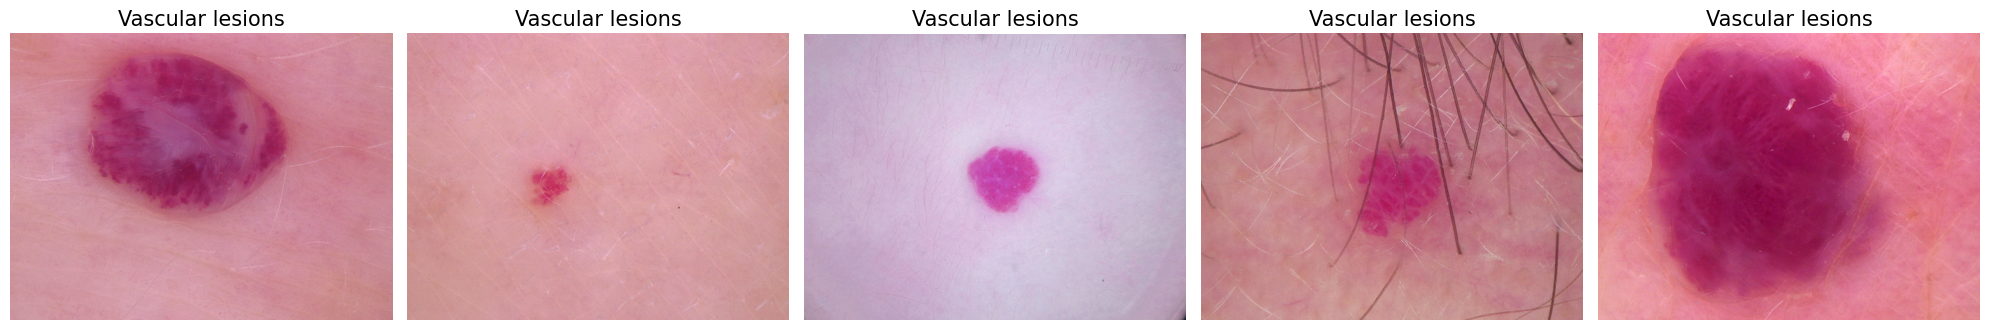

In [13]:
def display_cancer_types(images_dict,image_directory):
    for cancer_type in images_dict.keys():
        # Get image filenames
        image_files = images_dict[cancer_type][:5]

        # Set up the matplotlib figure
        fig, axes = plt.subplots(1, len(image_files), figsize=(20, 10))

        # Display each image
        for ax, file_path in zip(axes, image_files):
            #Construct the full file path
            file_path = os.path.join(image_directory, file_path)


            #print(f"Trying to open: {file_path}")  # Print the file path
            try:
                with Image.open(file_path) as img:
                    ax.imshow(img)
                    ax.axis('off')  # Hide the axis
                ax.set_title(cancer_type, fontsize=15)
            except FileNotFoundError:
                print(f"File not found: {file_path}")

        plt.tight_layout()
        plt.show()

# Call the function
display_cancer_types(cancer_images_names, image_directory)


    


## 3.2 Preprocessing the One-hot encoding Y labels

In [14]:
#One hot encoding for the labels expect the image column from first dataframe
y = pd.get_dummies(df.drop(columns=['image']))

#print(y.values)
#Create a one hot encoded array for  Numpy Array    
y = np.array(y)

y

#For reecomendation, we can check the distribution of the y values between the classes

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

# 4. Splitting the data 

## 4.1 Train and Test Split

In [15]:
#Split the data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=42)

#Check the shape of the train and test sets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8512, 128, 128, 3)
(1503, 128, 128, 3)
(8512, 7)
(1503, 7)


## 4.2 Split Traind and Validation

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.10, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(6204, 128, 128, 3)
(690, 128, 128, 3)
(1503, 128, 128, 3)


# 5. Model  CNN

# 5.1 Building model 

ALL COPY PASTE WATCH OUT !

In [31]:
from keras.optimizers.legacy import Adam

In [58]:
#Create a model
num_labels =7
model = Sequential()

#Add the layers to the model
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))

model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 conv2d_10 (Conv2D)          (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 63, 63, 64)        18496     
                                                                 
 conv2d_12 (Conv2D)          (None, 63, 63, 64)        36928     
                                                      

In [59]:
#Create a optimizer for the model and compile it
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None)

#Complie the model with cross-entropy loss function and adam optimizer
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])



In [53]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [56]:
#Set a early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

#Define the batch size and number of epochs 
batch_size=10

epochs=50

#Fit the model
history = model.fit(X_train, y_train, batch_size=batch_size,verbose=1, epochs=epochs, validation_data=(X_val, y_val),callbacks=[learning_rate_reduction,early_stopping])




Epoch 1/50


621/621 [==============================] - 48s 78ms/step - loss: 1.1351 - accuracy: 0.6696 - val_loss: 1.1282 - val_accuracy: 0.6754 - lr: 2.5000e-04
Epoch 2/50
621/621 [==============================] - 48s 77ms/step - loss: 1.1351 - accuracy: 0.6696 - val_loss: 1.1282 - val_accuracy: 0.6754 - lr: 2.5000e-04
Epoch 3/50
621/621 [==============================] - 48s 77ms/step - loss: 1.1351 - accuracy: 0.6696 - val_loss: 1.1282 - val_accuracy: 0.6754 - lr: 2.5000e-04
Epoch 4/50
620/621 [============================>.] - ETA: 0s - loss: 1.1348 - accuracy: 0.6697
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
621/621 [==============================] - 48s 78ms/step - loss: 1.1351 - accuracy: 0.6696 - val_loss: 1.1282 - val_accuracy: 0.6754 - lr: 2.5000e-04
Epoch 5/50
621/621 [==============================] - 48s 78ms/step - loss: 1.1350 - accuracy: 0.6696 - val_loss: 1.1282 - val_accuracy: 0.6754 - lr: 1.2500e-04
Epoch 6/50
621/621 [=========================

Test loss: 61.07271957397461
Test accuracy: 0.02594810351729393


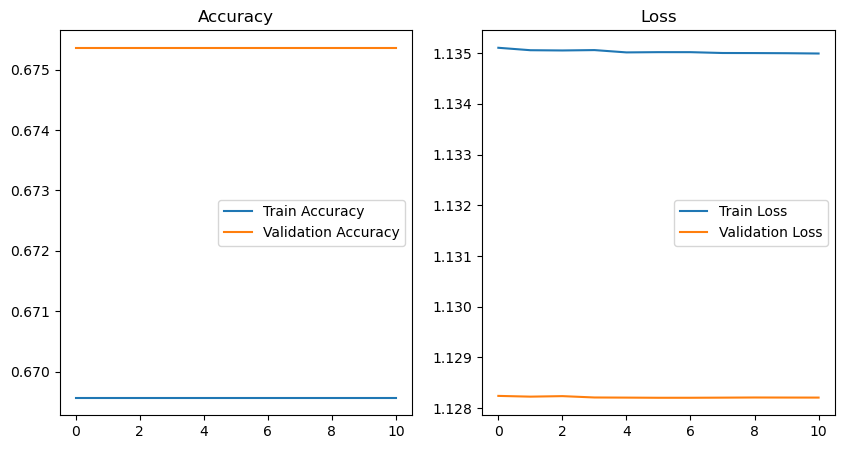

In [60]:
#Check the accuracy and loss of the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#Show them for each epochs in a graph 
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

